In [4]:
"""
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhbagchi/deepfake-image-detection")

print("Path to dataset files:", path)
"""
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt



In [83]:
import os
import shutil

# Eski klasörlerin yolları
original_dirs = [
    r"C:\Users\merts\Desktop\DeepFakeDetection\deepfake-image-detection\versions\2\train-20250112T065955Z-001\train\fake",
    r"C:\Users\merts\Desktop\DeepFakeDetection\deepfake-image-detection\versions\2\train-20250112T065955Z-001\train\real",
    r"C:\Users\merts\Desktop\DeepFakeDetection\deepfake-image-detection\versions\2\test-20250112T065939Z-001\test\fake",
    r"C:\Users\merts\Desktop\DeepFakeDetection\deepfake-image-detection\versions\2\test-20250112T065939Z-001\test\real"
]

# Yeni klasör yapısı
new_base = "data"
os.makedirs(os.path.join(new_base, "fake"), exist_ok=True)
os.makedirs(os.path.join(new_base, "real"), exist_ok=True)

# Verileri taşı (veya kopyala)
for folder in original_dirs:
    label = os.path.basename(folder)  # 'fake' or 'real'
    for img_name in os.listdir(folder):
        src = os.path.join(folder, img_name)
        dst = os.path.join(new_base, label, f"{label}_{img_name}")  # dosya ismi çakışmasın diye prefix ekliyoruz
        shutil.copy2(src, dst)  # or shutil.move(src, dst) eğer taşımak istiyorsan


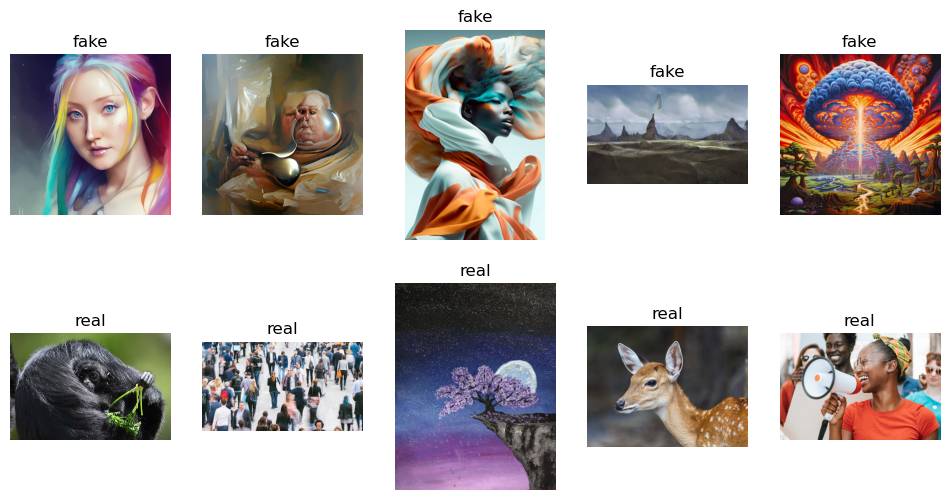

In [85]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Define dataset path
dataset_path = r"C:\Users\merts\Desktop\DeepFakeDetection\data"
# List categories (fake & real)
categories = [category for category in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, category))]

# Load sample images (filter out directories)
sample_images = []
for category in categories:
    class_path = os.path.join(dataset_path, category)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
    for img in images[:5]:  # Limit to first 5 images per category
        img_path = os.path.join(class_path, img)
        sample_images.append((img_path, category))

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (img_path, label) in enumerate(sample_images):
    img = load_img(img_path)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")
plt.show()


In [91]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split


IMG_SIZE = (128, 128)  # Resize images
BATCH_SIZE = 32

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)  # Resize
    img_array = img_to_array(img) / 255.0  # Normalize
    return img_array

# Load all images and labels
image_data = []
labels = []
label_map = {category: idx for idx, category in enumerate(categories)}

for category in categories:
    class_path = os.path.join(dataset_path, category)
    images = os.listdir(class_path)
    for img in images:
        img_path = os.path.join(class_path, img)
        image_data.append(load_and_preprocess_image(img_path))
        labels.append(label_map[category])

# Convert to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (703, 128, 128, 3), Validation shape: (79, 128, 128, 3), Test shape: (196, 128, 128, 3)


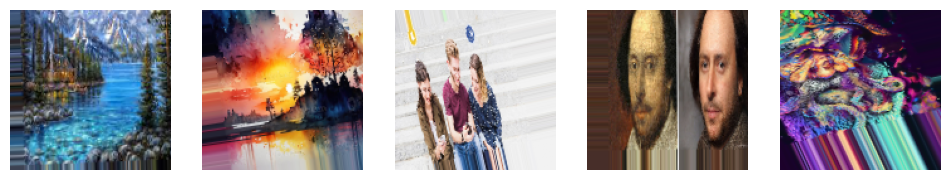

In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generate augmented images
augmented_images = datagen.flow(X_train[:5], batch_size=5)

# Display augmented images
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, img in enumerate(augmented_images):  # Only one batch of 5 images
    if i >= 1:  # Only process the first batch
        break
    for j in range(5):  # Loop through the 5 images in the batch
        axes[j].imshow(img[j])  # img[j] is the individual image in the batch
        axes[j].axis("off")
plt.show()

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam

# CNN modelini tanımla
model = Sequential([
    # İlk konvolüsyonel katman
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    
    # İkinci konvolüsyonel katman
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Üçüncü konvolüsyonel katman
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    #dördüncü katman
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flatten katmanı
    Flatten(),
    
    # Tam bağlantılı katman
    Dense(128, activation='relu'),
    Dropout(0.5),  
    
    # Çıkış katmanı
    Dense(2, activation='softmax')  # 2 sınıf için softmax çıkışı
])

# Modeli derle
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',  # Çok sınıflı sınıflandırma için
              metrics=['accuracy'])

# Early stopping ekleyelim
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Modelin özeti
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,568,450 (5.98 MB)

 Trainable params: 1,568,450 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

In [143]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    verbose=1)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.7316 - loss: 0.5459 - val_accuracy: 0.7595 - val_loss: 0.5488
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.7172 - loss: 0.5241 - val_accuracy: 0.7089 - val_loss: 0.5857
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.7324 - loss: 0.5563 - val_accuracy: 0.7342 - val_loss: 0.5358
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.7494 - loss: 0.5025 - val_accuracy: 0.7468 - val_loss: 0.4984
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.7760 - loss: 0.5212 - val_accuracy: 0.7595 - val_loss: 0.5281
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.7464 - loss: 0.5186 - val_accuracy: 0.7215 - val_loss: 0.5448
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.7743 - loss: 0.4974 - val_accuracy: 0.7089 - val_loss: 0.5603
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.7423 - loss: 0.5284 - val_accuracy: 0.

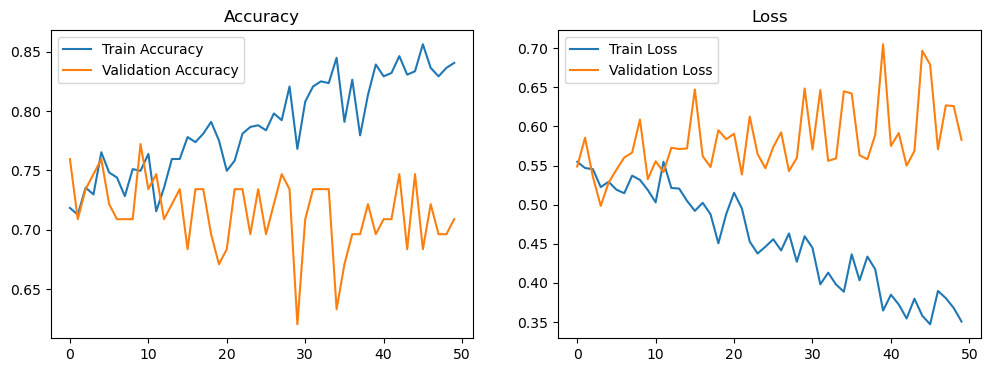

In [145]:
# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()

In [173]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7935 - loss: 0.5535
Test Accuracy: 0.7653


In [171]:
model.save('fake_image_detector_model.keras')


In [193]:
from tensorflow.keras.preprocessing import image
import numpy as np
# Load and preprocess your image (adjust path and image size as necessary)
input_img = image.load_img(r"C:\Users\merts\Desktop\DeepFakeDetection\samples_to_test\r_images1.jpg", target_size=(128, 128))  
input_array = image.img_to_array(input_img)
input_array = np.expand_dims(input_array, axis=0)  # Add batch dimension

# Normalize image to match the input used for training (if required)
input_array = input_array / 255.0  # Assuming model was trained with normalized images

# Get predictions from the model
predictions = model(input_array)

# Print the raw output (prediction probabilities for each class)
print("Raw predictions (probabilities for each class):", predictions)

# If it's a classification task, get the class with the highest probability
predicted_class_idx = np.argmax(predictions, axis=-1)  # Get index of max probability
print(f"Predicted class index: {predicted_class_idx}")

# If you have class labels, you can map this index back to a class name
class_labels = ['fake', 'real']  
predicted_class_name = class_labels[predicted_class_idx[0]]  # For single image
print(f"Predicted class name: {predicted_class_name}")

# Optionally, if you have true labels, you can also print accuracy and compare
# true_label = ...  # Load true label for comparison
# accuracy = np.mean(predicted_class_idx == true_label)
# print(f"Accuracy: {accuracy * 100:.2f}%")

Raw predictions (probabilities for each class): tf.Tensor([[0.61573344 0.38426653]], shape=(1, 2), dtype=float32)
Predicted class index: [0]
Predicted class name: fake
